In [2]:
import os
import pandas as pd
import numpy as np
import pandas as pd
#import seaborn as sns
from matplotlib import pyplot as plt



In [4]:
#%% functions
#read in all the data into one pandas frame
def create_df(source):
    source_dir = '/home/sreenath/Documents/Work/NOAA/SPLASH/' + source
    print(source_dir)
    
    #move into the iop folder
    os.chdir(source_dir)
    
    df = pd.DataFrame()
    for i, file_name in enumerate(os.listdir(source_dir)):
        if file_name.endswith('.FLX1'):
            print(file_name)
    #        print(i)
            x = pd.read_table(file_name,delimiter=r"\s+")
            df = pd.concat([df,x],axis=0)
        if file_name.endswith('Summary.txt'):
            print(file_name)
    #        print(i)
            x = pd.read_table(file_name,delimiter=r"\s+",skiprows=[1])
            df = pd.concat([df,x],axis=0)
    return df



/home/sreenath/Documents/Work/NOAA/SPLASH/Tower_Data/Kettle_Ponds/KPA22_001-365
KPA22_298.FLX1
KPA22_226.FLX1
KPA22_262.FLX1
KPA22_187.FLX1
KPA22_173.FLX1
KPA22_334.FLX1
KPA22_066.FLX1
KPA22_103.FLX1
KPA22_091.FLX1
KPA22_311.FLX1
KPA22_122.FLX1
KPA22_304.FLX1
KPA22_125.FLX1
KPA22_247.FLX1
KPA22_204.FLX1
KPA22_048.FLX1
KPA22_337.FLX1
KPA22_264.FLX1
KPA22_201.FLX1
KPA22_348.FLX1
KPA22_254.FLX1
KPA22_052.FLX1
KPA22_138.FLX1
KPA22_296.FLX1
KPA22_032.FLX1
KPA22_210.FLX1
KPA22_011.FLX1
KPA22_289.FLX1
KPA22_170.FLX1
KPA22_018.FLX1
KPA22_013.FLX1
KPA22_301.FLX1
KPA22_039.FLX1
KPA22_278.FLX1
KPA22_198.FLX1
KPA22_342.FLX1
KPA22_335.FLX1
KPA22_332.FLX1
KPA22_045.FLX1
KPA22_231.FLX1
KPA22_177.FLX1
KPA22_012.FLX1
KPA22_151.FLX1
KPA22_294.FLX1
KPA22_307.FLX1
KPA22_269.FLX1
KPA22_070.FLX1
KPA22_236.FLX1
KPA22_190.FLX1
KPA22_135.FLX1
KPA22_058.FLX1
KPA22_237.FLX1
KPA22_283.FLX1
KPA22_102.FLX1
KPA22_364.FLX1
KPA22_078.FLX1
KPA22_359.FLX1
KPA22_169.FLX1
KPA22_221.FLX1
KPA22_153.FLX1
KPA22_191.FLX1
KPA22

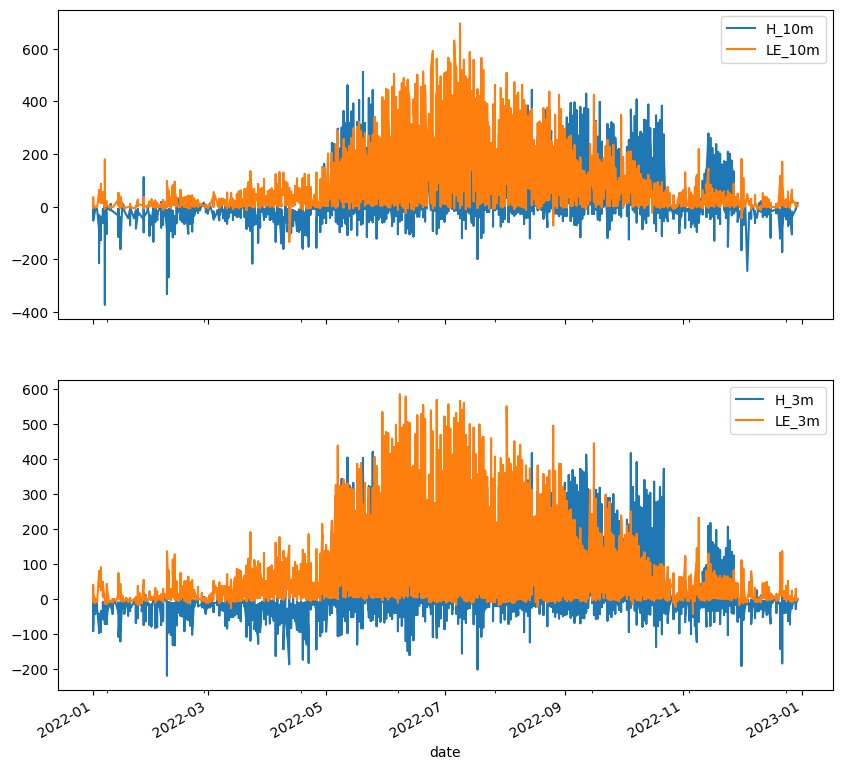

In [5]:

#%%##### Create a flux dataset to pull in sigma_w. You can collapse this if of no interest.

#%pwd
#source directory inside SPLASH directory
#source = 'Tower_Data/Kettle_Ponds/KPA22_001-365'
file_dir = 'Tower_Data/Kettle_Ponds/KPA22_001-365'
KP10_flux_df = create_df(file_dir)

file_dir = 'Tower_Data/Kettle_Ponds/KPB22_001-365'
KP03_flux_df = create_df(file_dir)

#%%
KP10_flux_df['date'] = pd.to_datetime(KP10_flux_df.date,format='%Y-%m-%d')
KP03_flux_df['date'] = pd.to_datetime(KP03_flux_df.date,format='%Y-%m-%d')

#%%

fig, (ax1, ax2) = plt.subplots(2, 1,  sharex=True, sharey=False, figsize=(10, 10))

def flux_qc_10(flux_df):
    #NAN filter
    H_f1 = flux_df['H_10m']!=-999
    #qc flag
    H_f2 = flux_df['qc_H'] < 1

    LE_f1 = flux_df['LE_10m']!=-999
    #qc flag
    LE_f2 = flux_df['qc_LE'] < 1
    
    return(flux_df.loc[H_f1 & H_f2 & LE_f1 & LE_f2])


def flux_qc_03(flux_df):
    #NAN filter
    H_f1 = flux_df['H_3m']!=-999
    #qc flag
    H_f2 = flux_df['qc_H'] < 1

    LE_f1 = flux_df['LE_3m']!=-999
    #qc flag
    LE_f2 = flux_df['qc_LE'] < 1
    
    return(flux_df.loc[H_f1 & H_f2 & LE_f1 & LE_f2])


flux_qc_10(KP10_flux_df).plot(x='date',y='H_10m',ax=ax1)
flux_qc_10(KP10_flux_df).plot(x='date',y='LE_10m',ax=ax1)

flux_qc_03(KP03_flux_df).plot(x='date',y='H_3m',ax=ax2)
flux_qc_03(KP03_flux_df).plot(x='date',y='LE_3m',ax=ax2)

#%% 

KP10_flux_qc_df = flux_qc_10(KP10_flux_df).copy()


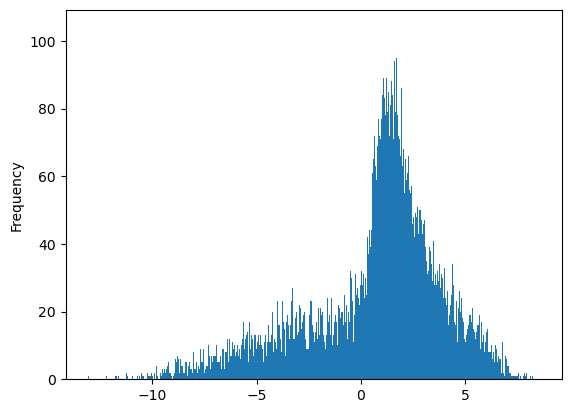

In [6]:

#use the 30-min met data to subset for the day and when delta_T (10_m - surf) < 0
file_path = '/home/sreenath/Documents/Work/NOAA/SPLASH/Tower_Data/Kettle_Ponds/met_data_v23052024/'
file_name = 'KP22_001-365.MET30X'
kp_met_df = pd.read_table(file_path + file_name,delimiter=r"\s+")#,skiprows = [1])

#%%

kp_met_df['date_time'] = pd.to_datetime((kp_met_df.date.astype(str) + ' ' + kp_met_df['time(MST)']))
kp_met_df = kp_met_df.set_index('date_time')

#i need a column for delta_T (let's say 10m - surf)
#take mean 10m and surf temperatures

kp_met_df['Tair_10m_mean'] = (kp_met_df['Tair1_10m'] + kp_met_df['Tair2_10m'])/2
kp_met_df['SurfT_C_mean'] = (kp_met_df['SurfT1_C'] + kp_met_df['SurfT2_C'] + + kp_met_df['SurfT3_C'])/3

kp_met_df['delta_T']  =  kp_met_df['Tair_10m_mean'] - kp_met_df['SurfT_C_mean']

#%% have a look at the data

filter = kp_met_df.delta_T > -100
kp_met_df.loc[filter].delta_T.plot.hist(bins=1000)

#subset for data != -999

kp_met_df = kp_met_df.loc[filter].copy()

#%% #now subset this data for the months and for daytime (net rad > 25 w/m2 ; not doing now)

#day_f1 = kp_met_df.Rg_in_avg >= 25

month_f1 = kp_met_df.index.month >= 6 
month_f2 = kp_met_df.index.month <= 10 

#delta_T_f = kp_met_df.delta_T > 0.5

#commenting out the delta_T flag. 20240905 paleri
kp_met_df_subset =  kp_met_df.loc[month_f1 & month_f2].sort_index().copy()


In [7]:

#%% 
#create a flux df, for delta_u, delta_v

KPA_flux_df_22 = flux_qc_10(KP10_flux_df).copy()
#set datetime as index
KPA_flux_df_22['date_time'] = pd.to_datetime((KPA_flux_df_22.date.astype(str) + ' ' + KPA_flux_df_22['time(MST)']))
KPA_flux_df_22 = KPA_flux_df_22.set_index('date_time')

#select filtered fluxes for months of june to august

H_month1 = KPA_flux_df_22.index.month >= 6 
H_month2 = KPA_flux_df_22.index.month <= 10 
H_ustar = KPA_flux_df_22['u*_10m'] >= 0.1
H_small = np.abs(KPA_flux_df_22['H_10m']) >= 10

KPA_flux_df_22_subset =  KPA_flux_df_22.loc[H_month1 & H_month2 & H_ustar & H_small].sort_index().copy()


(-10.0, 10.0)

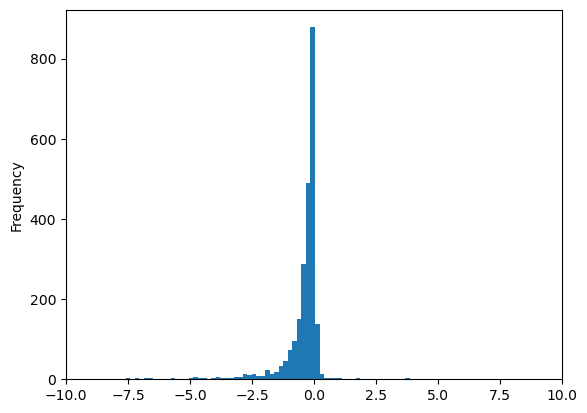

In [10]:

#%%

# calculate Rib

#right now I'm gonna use theta instead of theta_v. We don't have q measurements. Actually, we can get q from the EC system. It won't change much.
# delta_theta_v ~ delta_theta


KPA_flux_df_22_met = pd.merge(KPA_flux_df_22_subset,kp_met_df_subset, on='date_time')

g = 9.8


KPA_flux_df_22_met['delta_u'] = KPA_flux_df_22_met['u_unrot_10m']
KPA_flux_df_22_met['delta_v'] = KPA_flux_df_22_met['v_unrot_10m']

delta_z = 10.

KPA_flux_df_22_met['Rib'] = (g*KPA_flux_df_22_met['delta_T']*delta_z)/((KPA_flux_df_22_met['Tair_10m_mean']+273.15)*(KPA_flux_df_22_met.delta_u**2+KPA_flux_df_22_met.delta_v**2))

#%% plot Rib, hist
ax = KPA_flux_df_22_met.Rib.plot.hist(bins=1000)
ax.set_xlim([-10,10])

In [11]:
KPA_flux_df_22_met['sigma_w_10_non_dim'] = (KPA_flux_df_22_met['w_var_10m']**(0.5)/KPA_flux_df_22_met['wind_speed'])


(-8.0, 5.0)

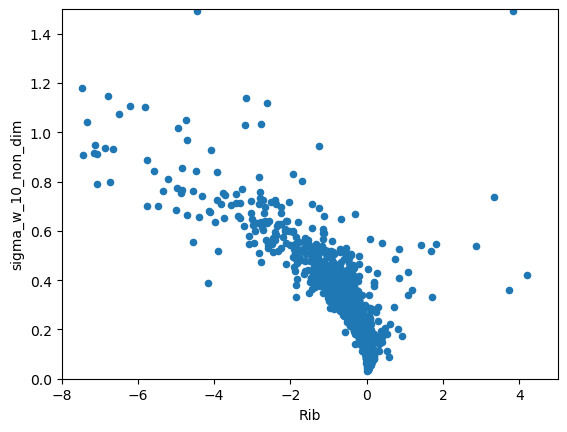

In [12]:
ax1 = KPA_flux_df_22_met.plot.scatter(x='Rib', y='sigma_w_10_non_dim')
#ax1.set_xscale('symlog')
ax1.set_ylim([0,1.5])
ax1.set_xlim([-8,5])